# Curriculum Learning: CNNs Applied to the Signal Detection Problem


This notebook demonstrates the use of __curriculum learning__ to detect wavelets within noisy time series data. The objective is to learn a binary label, which indicates whether or not a wavelet exists in a given time series. The classification task becomes increasingly difficult as the signal-to-noise ratio (SNR) decreases, thus rendering the wavelets indiscernible against the noise. 

This work is inspired by [1] and an application to astronomical data in [2]. 



## Imports 

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt

import keras

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import ReLU
from keras.layers import Reshape


from keras import optimizers
from keras.utils.vis_utils import plot_model

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from scipy import signal

from LSTMLib import *   #utility functions for time-windowing, adding noise, etc.


## A. Dataset

Here the dataset is created.

In [11]:
def create_wavelet_signal_detection_dataset(num_signals, 
                                             ricker_num_points, ricker_width_parameter,
                                             prob_is_signal, tt):
    
    X = np.empty((num_signals,len(tt)))
    Y = np.empty((num_signals,))
    
    #generate a common wavelet to be used
    wavelet_splice = signal.ricker(ricker_num_points, ricker_width_parameter)
    
    for idx in range(num_signals):
        
        # Bernoulli draw as to whether a wavelet will be inserted into a given
        # X_i
        Y[idx] = np.random.binomial(1, prob_is_signal, 1)
        
        if Y[idx]:
            wavelet_starting_index = int(np.random.uniform(0,len(tt)-ricker_num_points))
            
            #pure base wavelet signal
            sample = np.concatenate((np.zeros(wavelet_starting_index),wavelet_splice))
            sample = np.concatenate((sample,np.zeros(len(tt)-(ricker_num_points+wavelet_starting_index))))
        
        else:
            sample = np.zeros(len(tt))
            
        X[idx,:] = sample
    
    return X,Y
    


In [12]:
def create_noise_level_curriculum(X,Y,sigma,mu):
    """
    Create a dictionary in which keys are the noise level
    and the values are a dictionary of X and Y values
    """
    curriculum_dict = {}
    for sig in sigma:
        noise_level_set = {}
        noise_level_set['Y'] = np.array(Y)
        X_noisy = np.empty(X.shape)
        for idx in range(len(X)):
            X_noisy[idx,:] = additive_gaussian_noise(X[idx,:],mu,sig)
        
        noise_level_set['X'] = X_noisy
        
        curriculum_dict[sig] = noise_level_set
        
    return curriculum_dict

In [21]:
def create_test_train_split(X,Y, test_proportion):
    """
    create the test-train split for a given noise level
    """
    
    for i in range(len(X)):
        if i == 0:
            X_matrix = np.array(X[i,:])
            Y_matrix = np.array(Y[i])
        else:
            X_matrix= np.vstack((X_matrix, X[i,:]))
            Y_matrix = np.vstack((Y_matrix,Y[i]))
    
    #convert the 1,0 target variable to categorical using keras
    Y_matrix= tf.keras.utils.to_categorical(Y_matrix)
    
    X_train, X_test, y_train, y_test = train_test_split(X_matrix, Y_matrix, test_size=test_proportion)
    
    return X_train, X_test, y_train, y_test

In [22]:
#random seed
np.random.seed(0)

#global signal parameters
T = 100.  #seconds
fs = 50. #sampling frequency
tt = np.linspace(0,T,int(T*fs))

#dataset parameters
num_noise_levels = 20
num_signals = 100

# Bernoulli probability as to whether a wavelet will be inserted into a given
# X_i
prob_has_wavelet = 0.5


#wavelet parameters
ricker_time_interval = 1.0
ricker_width_parameter=4.0
ricker_num_points = int(fs/ricker_time_interval)

#noise parameters
sigmas = np.linspace(0.001,0.5,num_noise_levels) #sd/rms ampltiude of noise 
mu = 0


In [23]:
# generate dataset

X, Y = create_wavelet_signal_detection_dataset(num_signals, ricker_num_points, ricker_width_parameter, 
                                               prob_has_wavelet, tt)
    
curriculum_dict = create_noise_level_curriculum(X,Y,sigmas,mu)
        

### Dataset Description

The dataset is composed of mutiple time series which may or may not contain Ricker ("Mexican hat") wavelets. The  parameters of the wavelet are fixed, as are the length of each time series in the dataset. For those series that do contain wavlets, the time offset of the wavelet from the begining of the series will vary, in order to add additional randomness to the data. A fixed sampling frequency is used for all series in the dataset.

Within a given series a wavelet signal may or may not exist. The existence of a wavelet signal in a given segment is denoted by a binary label $\mathbf{Y}$, the target variable in the classification problem. 

To create a dataset useful in the context of curriculum learning, various levels of additive white Gaussian noise (AWGN) have been added to the noiseless dataset described above. The level of the Gaussian noise is defined by its standard deviation $\sigma_{noise}$ . 20 such levels have been chosen, ranging from $\sigma_{noise} =0.001 \text{ to } 0.5$ . The baseline (i.e. noiseless) dataset contains 100 time series. The entire dataset is therefore composed of 100x20 = 2000 time series. 



#### Summary of Dataset Parameters

|       Parameter                           |                Value   |
|------------------------------------------------|:--------------------------------:|
|             Training Set Size                        |          0.7     |
|               Test Set Size                         |          0.3      |
|               Batch Size                          |          400      |
|               $\sigma_{noise}$      |          [0.001, 0.5]     |
|               $ N_{signals}$ per Noise Level|  100                 |

### Plots of Example Dataset at Various Noise Levels

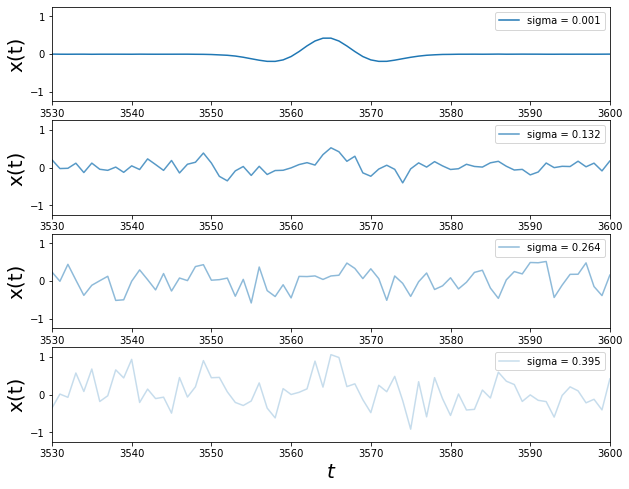

In [24]:
plt.figure(figsize=(10,8))
num_subplots = int(num_noise_levels/5)
plot_count=1
for idx in range(num_noise_levels):
    if idx%5 ==0:
        plt.subplot(num_subplots,1,plot_count)
        plt.plot(curriculum_dict[sigmas[idx]]['X'][0], alpha=1.0-float(idx)/num_noise_levels, \
                 label = "sigma = %.3f"%sigmas[idx])
        plot_count+=1
        plt.legend(fontsize=10)
        plt.xlabel(r"$t$", fontsize=20)
        plt.ylabel("x(t)", fontsize=20)
        plt.ylim([-1.25,1.25])
        plt.xlim([3530,3600])
plt.show()   


## B.  Model Setup

### Model Parameters


`KERNEL_SIZE`: the size of the sliding window across the data. Also referred to as the filter length.

`WIDTH`: the dimensionality of the data (in this case 1, as it is a 1-D time series. 

`HEIGHT`: the length/number of samples of the time series data utilized. 

`NUM_FILTERS`: the number of filters learned by the network on a given layer. Corresponds to the number of features for which one wants to train in that layer. Choosing a higher value for this parameter makes sense as allow the layer to explore a number of possible features, one or more of which will closely learn the feature one is hoping to filter from the data. 



`POOL_SIZE`: in a Max Pooling layer, the _pool_ _size_  parameter specifies the number of features computed in the preceding Convulutional layer which are to be selected and forwarded to the subsequent layers. The features are selected by max value, hence the name. 

`NUM_CLASSES`: For classification problems, specifies the number of classes to which probalities will be assigned by the terminal Softmax layer in the network. 


__NOTE:__ The purpose of the first `Reshape` layer is renderd moot, since it is not actually reshaping the data. However, it would have utility in other cases where the input data would either need to be flattened, or conversely expanded from flattened to multidimensional form (e.g. X,Y,Z trajectory information concatenated to each other). 


### Purpose of the Layers 

__Conv1D__ : Application of filters of the specified kernel size. Each filter is a "candidate filter" that attempts to learn a feature in the data. 

__MaxPooling1D__: Selection of the most strongly stimulated filters of the candidate filters in the previous layer. Useful to avoid overfitting. 

__GlobalAveragePooling1D__: Selection of the filters of the candidate filters in the previous  with highest average value between two weights. Useful to avoid overfitting. 

__Dropout__: Assign a certain proportion of weights a '0' value. Reduces sensitivity to small variations in the data. 

__Dense__: A fully-connected layer. When Softmax activation on `NUM_CLASSES` is used, it will produce probailities for the number of specified classes. For this problem, the two classes are 'contains signal' and 'does not contain signal' for detection of the wavelet anomaly. 

In [25]:
TIMESTEPS = len(tt) 
KERNEL_SIZE = 16
WIDTH = 1 
HEIGHT = TIMESTEPS
NUM_FILTERS = 100
POOL_SIZE = 4
NUM_CLASSES = 2 # one class: "is signal", the other "is not signal"

input_shape = TIMESTEPS

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 5000, 1)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 4985, 100)         1700      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1246, 100)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 1231, 100)         160100    
                                                                 
 conv1d_5 (Conv1D)           (None, 1216, 100)         160100    
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                             

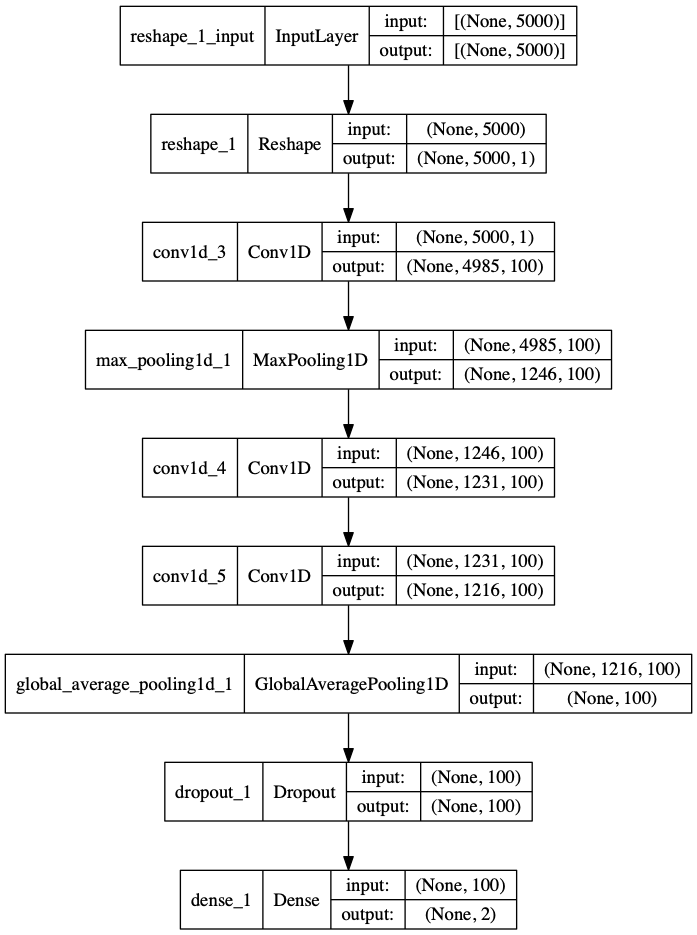

In [26]:
model = Sequential()
model.add(Reshape((HEIGHT, WIDTH),input_shape=(TIMESTEPS,)))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu', input_shape=(HEIGHT,WIDTH)))
model.add(MaxPooling1D(pool_size=POOL_SIZE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

print(model.summary())

plot_model(model, show_shapes=True)




### Baseline Classifier Performance without Curriculum Learning, Single-fold Validation

Here we randomly pick samples from the dataset, across all the noise levels, to observe the performance of the architecture in the absence of curriculum learning. 

In [30]:
X_train, X_test, Y_train, Y_test = create_test_train_split(curriculum_dict[sigmas[-1]]['X'],\
                                                           curriculum_dict[sigmas[-1]]['Y'], 0.3)
    

`BATCH_SIZE` - Number of samples before gradient update. 

`EPOCHS`  - Number of gradient updates. 

In [31]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 75

history = model.fit(X_train,
                      Y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/75
1/1 [==============================] - 1s 1s/step - loss: 1893.9929 - accuracy: 0.5893 - val_loss: 0.3402 - val_accuracy: 0.9286
Epoch 2/75
1/1 [==============================] - 1s 1s/step - loss: 1771.1204 - accuracy: 0.5893 - val_loss: 0.3998 - val_accuracy: 0.9286
Epoch 3/75
1/1 [==============================] - 1s 969ms/step - loss: 1561.7760 - accuracy: 0.5893 - val_loss: 0.4773 - val_accuracy: 0.9286
Epoch 4/75
1/1 [==============================] - 1s 993ms/step - loss: 1432.1272 - accuracy: 0.5893 - val_loss: 0.6377 - val_accuracy: 0.9286
Epoch 5/75
1/1 [==============================] - 1s 972ms/step - loss: 1218.4834 - accuracy: 0.5893 - val_loss: 0.9862 - val_accuracy: 0.8571
Epoch 6/75
1/1 [==============================] - 1s 980ms/step - loss: 1148.3175 - accuracy: 0.5893 - val_loss: 1.5324 - val_accuracy: 0.2143
Epoch 7/75
1/1 [==============================] - 1s 976ms/step - loss: 1042.6865 - accuracy: 0.5893 - val_loss: 2.1500 - val_accuracy: 0.2143
Epoch

1/1 [==============================] - 1s 1s/step - loss: 10.9023 - accuracy: 0.4107 - val_loss: 0.5928 - val_accuracy: 0.7857
Epoch 46/75
1/1 [==============================] - 1s 1s/step - loss: 9.1063 - accuracy: 0.4107 - val_loss: 0.5921 - val_accuracy: 0.7857
Epoch 47/75
1/1 [==============================] - 1s 1s/step - loss: 6.9021 - accuracy: 0.4107 - val_loss: 0.5939 - val_accuracy: 0.7857
Epoch 48/75
1/1 [==============================] - 1s 1s/step - loss: 4.9968 - accuracy: 0.4107 - val_loss: 0.5980 - val_accuracy: 0.7857
Epoch 49/75
1/1 [==============================] - 1s 1s/step - loss: 3.4494 - accuracy: 0.4286 - val_loss: 0.6037 - val_accuracy: 0.7857
Epoch 50/75
1/1 [==============================] - 1s 1s/step - loss: 2.4114 - accuracy: 0.4821 - val_loss: 0.6106 - val_accuracy: 0.7857
Epoch 51/75
1/1 [==============================] - 1s 1s/step - loss: 1.3053 - accuracy: 0.6071 - val_loss: 0.6176 - val_accuracy: 0.7857
Epoch 52/75
1/1 [============================

## Model Diagnostics

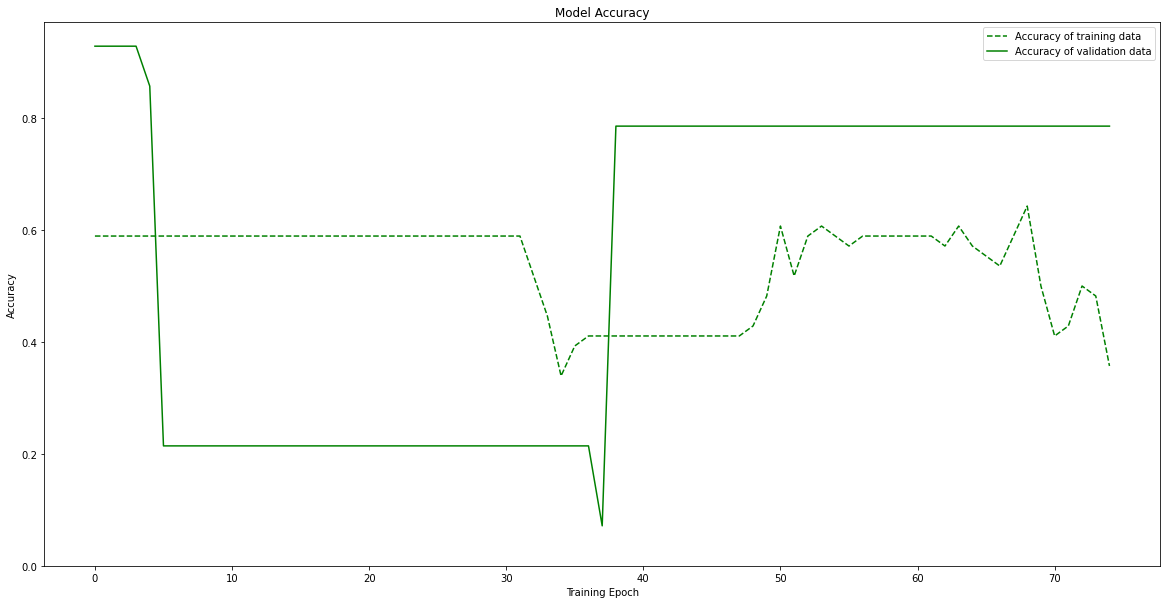

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [33]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

1/1 [==============================] - 0s 268ms/step - loss: 1.0926 - accuracy: 0.4000

Accuracy on test data: 0.40

Loss on test data: 1.09


In [34]:
Y_pred_test = model.predict(X_test)

In [35]:
max_y_pred_test = np.argmax(Y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

In [36]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=["Signal", "No signal"],
                yticklabels=["Signal", "No signal"],
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

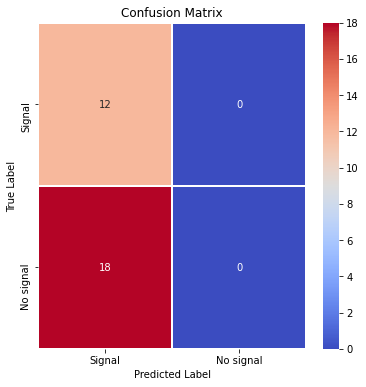

In [37]:
show_confusion_matrix(max_y_test, max_y_pred_test)

# C. Curriculum Learning

The curricula are datasets of gradually increasing size, with each dataset incorporating noiser and noiser data. The core subset(s) of low-noise data are retained in each new dataset so that each training session does not "catastrophically forget" the low-noise concepts. 

In [39]:
TIMESTEPS = len(tt) 
KERNEL_SIZE = 16
WIDTH = 1 
HEIGHT = TIMESTEPS
NUM_FILTERS = 100
POOL_SIZE = 4
NUM_CLASSES = 2 # one class: "is signal", the other "is not signal"

input_shape = TIMESTEPS

### Compile Model

In [40]:
model = Sequential()
model.add(Reshape((HEIGHT, WIDTH),input_shape=(TIMESTEPS,)))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu', input_shape=(HEIGHT,WIDTH)))
model.add(MaxPooling1D(pool_size=POOL_SIZE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 5000, 1)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 4985, 100)         1700      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1246, 100)        0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 1231, 100)         160100    
                                                                 
 conv1d_8 (Conv1D)           (None, 1216, 100)         160100    
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                             

In [41]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])



### Noise Level Iterations

In [43]:
BATCH_SIZE = 400
EPOCHS = 20

results = pd.DataFrame(columns = ['Sigma', 'Accuracy (Test)', 'Loss (Test)'])

_ ,X_test_max_noise, _ , Y_test_max_noise = create_test_train_split(curriculum_dict[sigmas[-1]]['X'],\
                                                                    curriculum_dict[sigmas[-1]]['Y'], 0.3)

X_test = None
X_train = None
Y_test = None
Y_train =None 


for idx,sig in enumerate(sigmas):
    
    X_train_idx, X_test_idx, Y_train_idx, Y_test_idx = create_test_train_split(curriculum_dict[sig]['X'],\
                                                                               curriculum_dict[sig]['Y'], 0.3)
    
    #accumulate the data 
    if (X_test is None) or (Y_test is None) or  (X_train is None) or (Y_train is None):
        X_test = X_test_idx
        Y_test = Y_test_idx
        
        X_train = X_train_idx
        Y_train = Y_train_idx
        
    else:
        X_test = np.concatenate((X_test,X_test_idx))
        Y_test = np.concatenate((Y_test,Y_test_idx))
        
        X_train = np.concatenate((X_train,X_train_idx))
        Y_train = np.concatenate((Y_train,Y_train_idx))
    

    #calling fit consecutively on the same model 
    #incrementally learns based on the previous state
    history = model.fit(X_train,
                        Y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
    
    
    #score = model.evaluate(X_test_max_noise, Y_test_max_noise , verbose=1)
    score = model.evaluate(X_test, Y_test , verbose=1)
    
    print("Sigma %0.3f"%sig)
    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])
    
    results = results.append(pd.DataFrame({'Sigma':[sig], 
                                           'Accuracy (Test)': [score[1]], 
                                           'Loss (Test)': [score[0]]}), 
                             ignore_index=True)
    
    #model.reset_states()
    
    

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.6932 - accuracy: 0.4107 - val_loss: 0.6818 - val_accuracy: 0.7143
Epoch 2/20
1/1 [==============================] - 1s 917ms/step - loss: 0.6861 - accuracy: 0.6250 - val_loss: 0.6552 - val_accuracy: 0.7143
Epoch 3/20
1/1 [==============================] - 1s 987ms/step - loss: 0.6715 - accuracy: 0.6250 - val_loss: 0.6158 - val_accuracy: 0.7143
Epoch 4/20
1/1 [==============================] - 1s 926ms/step - loss: 0.6482 - accuracy: 0.6250 - val_loss: 0.5920 - val_accuracy: 0.7143
Epoch 5/20
1/1 [==============================] - 1s 979ms/step - loss: 0.6833 - accuracy: 0.6250 - val_loss: 0.5929 - val_accuracy: 0.7143
Epoch 6/20
1/1 [==============================] - 1s 948ms/step - loss: 0.6632 - accuracy: 0.6250 - val_loss: 0.6025 - val_accuracy: 0.7143
Epoch 7/20
1/1 [==============================] - 1s 973ms/step - loss: 0.6546 - accuracy: 0.6250 - val_loss: 0.6162 - val_accuracy: 0.7143
Epoch 8/20
1/1 [=======

1/1 [==============================] - 3s 3s/step - loss: 0.6471 - accuracy: 0.6190 - val_loss: 0.6888 - val_accuracy: 0.5952
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 0.6441 - accuracy: 0.6190 - val_loss: 0.6748 - val_accuracy: 0.5952
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 0.6392 - accuracy: 0.6190 - val_loss: 0.6673 - val_accuracy: 0.5952
Epoch 8/20
1/1 [==============================] - 3s 3s/step - loss: 0.6442 - accuracy: 0.6190 - val_loss: 0.6631 - val_accuracy: 0.5952
Epoch 9/20
1/1 [==============================] - 3s 3s/step - loss: 0.6438 - accuracy: 0.6190 - val_loss: 0.6609 - val_accuracy: 0.5952
Epoch 10/20
1/1 [==============================] - 3s 3s/step - loss: 0.6416 - accuracy: 0.6190 - val_loss: 0.6603 - val_accuracy: 0.5952
Epoch 11/20
1/1 [==============================] - 3s 3s/step - loss: 0.6363 - accuracy: 0.6190 - val_loss: 0.6618 - val_accuracy: 0.5952
Epoch 12/20
1/1 [==============================] -

1/1 [==============================] - 5s 5s/step - loss: 0.4349 - accuracy: 0.9500 - val_loss: 2.3493 - val_accuracy: 0.6000
Epoch 10/20
1/1 [==============================] - 5s 5s/step - loss: 0.4091 - accuracy: 0.9036 - val_loss: 2.8549 - val_accuracy: 0.6000
Epoch 11/20
1/1 [==============================] - 5s 5s/step - loss: 0.3962 - accuracy: 0.9036 - val_loss: 3.1904 - val_accuracy: 0.6000
Epoch 12/20
1/1 [==============================] - 5s 5s/step - loss: 0.3822 - accuracy: 0.9036 - val_loss: 3.2334 - val_accuracy: 0.6000
Epoch 13/20
1/1 [==============================] - 5s 5s/step - loss: 0.3592 - accuracy: 0.9036 - val_loss: 2.9851 - val_accuracy: 0.6000
Epoch 14/20
1/1 [==============================] - 5s 5s/step - loss: 0.3231 - accuracy: 0.9393 - val_loss: 2.6262 - val_accuracy: 0.6000
Epoch 15/20
1/1 [==============================] - 5s 5s/step - loss: 0.3022 - accuracy: 0.9893 - val_loss: 2.4573 - val_accuracy: 0.6000
Epoch 16/20
1/1 [=============================

1/1 [==============================] - 7s 7s/step - loss: 0.1486 - accuracy: 0.9847 - val_loss: 2.4422 - val_accuracy: 0.6939
Epoch 14/20
1/1 [==============================] - 7s 7s/step - loss: 0.1499 - accuracy: 0.9847 - val_loss: 2.4394 - val_accuracy: 0.7143
Epoch 15/20
1/1 [==============================] - 7s 7s/step - loss: 0.1446 - accuracy: 0.9847 - val_loss: 2.3519 - val_accuracy: 0.7143
Epoch 16/20
1/1 [==============================] - 7s 7s/step - loss: 0.1312 - accuracy: 0.9872 - val_loss: 2.2200 - val_accuracy: 0.7347
Epoch 17/20
1/1 [==============================] - 7s 7s/step - loss: 0.1148 - accuracy: 0.9821 - val_loss: 2.0863 - val_accuracy: 0.7347
Epoch 18/20
1/1 [==============================] - 7s 7s/step - loss: 0.1040 - accuracy: 0.9796 - val_loss: 1.9897 - val_accuracy: 0.7143
Epoch 19/20
1/1 [==============================] - 7s 7s/step - loss: 0.1024 - accuracy: 0.9796 - val_loss: 1.9684 - val_accuracy: 0.7347
Epoch 20/20
7/7 [=============================

2/2 [==============================] - 10s 3s/step - loss: 0.0731 - accuracy: 0.9802 - val_loss: 3.0354 - val_accuracy: 0.6667
Epoch 18/20
2/2 [==============================] - 10s 3s/step - loss: 0.0780 - accuracy: 0.9802 - val_loss: 3.6051 - val_accuracy: 0.6587
Epoch 19/20
2/2 [==============================] - 10s 3s/step - loss: 0.0676 - accuracy: 0.9841 - val_loss: 4.6833 - val_accuracy: 0.6587
Epoch 20/20
9/9 [==============================] - 1s 140ms/step - loss: 1.0117 - accuracy: 0.9148
Sigma 0.211

Accuracy on test data: 0.91

Loss on test data: 1.01
Epoch 1/20
2/2 [==============================] - 10s 3s/step - loss: 0.2065 - accuracy: 0.9554 - val_loss: 6.8909 - val_accuracy: 0.6357
Epoch 2/20
2/2 [==============================] - 10s 3s/step - loss: 0.1950 - accuracy: 0.9321 - val_loss: 6.3519 - val_accuracy: 0.6357
Epoch 3/20
2/2 [==============================] - 10s 3s/step - loss: 0.1513 - accuracy: 0.9518 - val_loss: 8.6128 - val_accuracy: 0.6214
Epoch 4/20
2/2 [

11/11 [==============================] - 1s 126ms/step - loss: 1.7914 - accuracy: 0.8758
Sigma 0.264

Accuracy on test data: 0.88

Loss on test data: 1.79
Epoch 1/20
2/2 [==============================] - 11s 5s/step - loss: 0.3090 - accuracy: 0.9286 - val_loss: 9.0509 - val_accuracy: 0.6845
Epoch 2/20
2/2 [==============================] - 11s 5s/step - loss: 0.2869 - accuracy: 0.9077 - val_loss: 8.8305 - val_accuracy: 0.6786
Epoch 3/20
2/2 [==============================] - 11s 5s/step - loss: 0.2777 - accuracy: 0.9449 - val_loss: 8.8486 - val_accuracy: 0.6786
Epoch 4/20
2/2 [==============================] - 11s 5s/step - loss: 0.2394 - accuracy: 0.9420 - val_loss: 6.4042 - val_accuracy: 0.7024
Epoch 5/20
2/2 [==============================] - 11s 5s/step - loss: 0.2585 - accuracy: 0.8973 - val_loss: 8.1246 - val_accuracy: 0.6786
Epoch 6/20
2/2 [==============================] - 11s 5s/step - loss: 0.2429 - accuracy: 0.9435 - val_loss: 9.5964 - val_accuracy: 0.6607
Epoch 7/20
2/2 [=

Epoch 3/20
2/2 [==============================] - 12s 6s/step - loss: 0.3240 - accuracy: 0.9327 - val_loss: 11.6210 - val_accuracy: 0.6538
Epoch 4/20
2/2 [==============================] - 12s 6s/step - loss: 0.3039 - accuracy: 0.9286 - val_loss: 10.3897 - val_accuracy: 0.6538
Epoch 5/20
2/2 [==============================] - 13s 6s/step - loss: 0.3180 - accuracy: 0.8929 - val_loss: 10.9222 - val_accuracy: 0.6538
Epoch 6/20
2/2 [==============================] - 12s 6s/step - loss: 0.3049 - accuracy: 0.9176 - val_loss: 10.6692 - val_accuracy: 0.6538
Epoch 7/20
2/2 [==============================] - 12s 6s/step - loss: 0.2891 - accuracy: 0.9245 - val_loss: 8.0068 - val_accuracy: 0.6484
Epoch 8/20
2/2 [==============================] - 12s 6s/step - loss: 0.3029 - accuracy: 0.8984 - val_loss: 8.2764 - val_accuracy: 0.6484
Epoch 9/20
2/2 [==============================] - 12s 6s/step - loss: 0.2869 - accuracy: 0.9258 - val_loss: 10.1000 - val_accuracy: 0.6593
Epoch 10/20
2/2 [============

3/3 [==============================] - 14s 4s/step - loss: 0.4534 - accuracy: 0.8476 - val_loss: 16.2518 - val_accuracy: 0.6143
Epoch 8/20
3/3 [==============================] - 14s 4s/step - loss: 0.4516 - accuracy: 0.8155 - val_loss: 11.0547 - val_accuracy: 0.5857
Epoch 9/20
3/3 [==============================] - 14s 4s/step - loss: 0.5009 - accuracy: 0.8310 - val_loss: 30.3004 - val_accuracy: 0.6143
Epoch 10/20
3/3 [==============================] - 14s 4s/step - loss: 0.8035 - accuracy: 0.7798 - val_loss: 11.6057 - val_accuracy: 0.5905
Epoch 11/20
3/3 [==============================] - 14s 4s/step - loss: 0.4692 - accuracy: 0.8155 - val_loss: 15.8482 - val_accuracy: 0.6143
Epoch 12/20
3/3 [==============================] - 14s 4s/step - loss: 0.4887 - accuracy: 0.7012 - val_loss: 10.1023 - val_accuracy: 0.5905
Epoch 13/20
3/3 [==============================] - 14s 4s/step - loss: 0.4207 - accuracy: 0.8821 - val_loss: 12.4657 - val_accuracy: 0.6238
Epoch 14/20
3/3 [=================

3/3 [==============================] - 20s 6s/step - loss: 0.5675 - accuracy: 0.6712 - val_loss: 3.9232 - val_accuracy: 0.6176
Epoch 12/20
3/3 [==============================] - 18s 6s/step - loss: 0.5655 - accuracy: 0.6765 - val_loss: 3.3153 - val_accuracy: 0.6092
Epoch 13/20
3/3 [==============================] - 18s 6s/step - loss: 0.5591 - accuracy: 0.6712 - val_loss: 4.0800 - val_accuracy: 0.6134
Epoch 14/20
3/3 [==============================] - 18s 5s/step - loss: 0.5648 - accuracy: 0.6691 - val_loss: 4.4119 - val_accuracy: 0.6176
Epoch 15/20
3/3 [==============================] - 18s 5s/step - loss: 0.5526 - accuracy: 0.6754 - val_loss: 4.1246 - val_accuracy: 0.6134
Epoch 16/20
3/3 [==============================] - 18s 5s/step - loss: 0.5497 - accuracy: 0.6754 - val_loss: 4.5530 - val_accuracy: 0.6134
Epoch 17/20
3/3 [==============================] - 18s 5s/step - loss: 0.5478 - accuracy: 0.6796 - val_loss: 4.5474 - val_accuracy: 0.6134
Epoch 18/20
3/3 [======================

3/3 [==============================] - 19s 6s/step - loss: 0.5871 - accuracy: 0.6617 - val_loss: 3.1428 - val_accuracy: 0.6090
Epoch 16/20
3/3 [==============================] - 19s 6s/step - loss: 0.5851 - accuracy: 0.6513 - val_loss: 3.7373 - val_accuracy: 0.6391
Epoch 17/20
3/3 [==============================] - 19s 6s/step - loss: 0.5961 - accuracy: 0.6551 - val_loss: 3.8893 - val_accuracy: 0.6391
Epoch 18/20
3/3 [==============================] - 19s 6s/step - loss: 0.5863 - accuracy: 0.6485 - val_loss: 2.8271 - val_accuracy: 0.5714
Epoch 19/20
3/3 [==============================] - 19s 6s/step - loss: 0.6019 - accuracy: 0.6532 - val_loss: 4.0983 - val_accuracy: 0.6429
Epoch 20/20
18/18 [==============================] - 3s 155ms/step - loss: 1.2230 - accuracy: 0.6175
Sigma 0.474

Accuracy on test data: 0.62

Loss on test data: 1.22
Epoch 1/20
3/3 [==============================] - 20s 7s/step - loss: 0.6163 - accuracy: 0.6607 - val_loss: 3.1226 - val_accuracy: 0.5500
Epoch 2/20
3

# Results

In [46]:
#results_reset_state = results

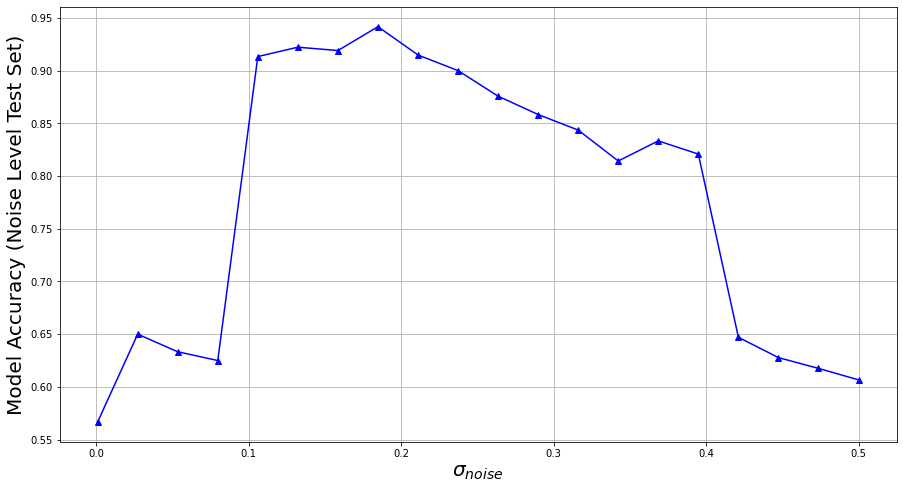

In [49]:
plt.figure(figsize=(15,8))
plt.plot(results['Sigma'], results['Accuracy (Test)'], '-^b')
plt.xlabel(r"$\sigma_{noise}$", fontsize=20)
plt.ylabel("Model Accuracy (Noise Level Test Set)", fontsize=20)
plt.grid()
plt.show()

When trained in the usual fashion (i.e. without the iterations of curriculum learning), the classifier easily attains 100% accuracy against the noiseless data. When evaluated against the noisiest data, it yields 40% accuracy, which is worse than no-skill classification (i.e. pretty bad). 
    
With curriculum learning, the model yields ~85% accuracy across the entire dataset when the Gaussian noise standard deviation $\sigma_{noise}$ is less than 0.4, but falls when $\sigma_{noise}$ increases beyond 0.4. The increase in $\sigma_{noise}$ corresponds to a decrease in SNR. The decrease in accuracy with the addition of lower SNR data in the latter curriculum iterations suggest that there is only so much noise that a curriculum-trained model can tolerate, and that there are definite limitations to the curriculum learning method.


__Accuracy dependence on Number of Training Epochs on Each Curriculum Dataset__:

The below observations of the test set accuracy dependence on number of epochs per training set show the effect of under- and over-training when incrementally adding noisier data to the dataset. 

For a low of number of epochs, the network does not learn the target concept at _any_ noise level. That is, the epoch number is globally suboptimal. 

For a high of number of epochs, the network overtrains to high SNR data, and utterly fails on data with even a small amount of noise. 

For the optimal epoch regime (around 20 per curriculum dataset/noise level), the network learns the lowest noise dataset almost perfectly. It suffers in having to re-learn even slightly noisy data, then quickly refines its concept to achieve a decent accuracy on intermediate noise levels. As expected, it slowly loses accuracy as the SNR decreases.  
    
|      Epochs                       |                Test Set Accuracy   |
|------------------------------------------------|:--------------------------------:|
|               10       |          Fluctuates about 60% for all $\sigma$     |
|               20     |           Plateaus around 85% until $\sigma=0.4$    |
|               30       |          Quickly decays to 50%  (i.e. no-skill)   |
|               40       |          Quickly decays to 50%  (i.e. no-skill)  |


# References

[1] https://arxiv.org/pdf/1904.03626.pdf  (Review of Curriculum Learning)

[2] https://arxiv.org/pdf/1701.00008.pdf  (Application to LIGO Astronomical Data)



[3] https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

[4] https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf 

[5] https://keras.io/api/layers/convolution_layers/convolution1d/

[6] https://keras.io/api/layers/pooling_layers/max_pooling1d/

 



